In [1]:
from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import BatchIterator
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet
import time


import pickle
import gzip
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
import matplotlib.pyplot as plt
import matplotlib.image as imgplot

%load_ext rpy2.ipython

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 1: GeForce GTX 780


### Loading of the data

In [3]:
start = time.time()
if False: #hdf5
    with gzip.open('data/data.pkl.gz', 'rb') as f:
        X,Y = pickle.load(f)
#Inselspital
with open('/home/dueo/data/Inselspital_2015_07_08/GBM.pickle') as f:
    Names,X,Y,l = pickle.load(f)
print ("Loaded data in " + str(time.time() - start))
print ("   " + str(X.shape) + " y " + str(Y.shape))

Loaded data in 1.84358906746
   (1110, 1, 256, 256) y (1110, 1, 256, 256)


#### Normalisation

In [4]:
X = X / X.max() #Simple Normalization, I don't want to remove the zeros since I think they have information


# Z-Transformation
#Xmean = X.mean(axis = 0)
#XStd = np.sqrt(X.var(axis=0))
#X = (X-Xmean) / 1000

# Unrolled for analysis in R
Xf = X.reshape(1110*256*256)
yyf = np.array(Y.reshape(1110*256*256))
%Rpush Xf
%Rpush yyf
%Rpush l

### Verteilung der Pixelwerte

In [ ]:
%%R 
library (ggplot2)
qplot(Xf)

#### Distribution of the annotation


The distribution of the different codings. From E-Mail:

label 1: reference normal tissue. In my master thesis I scaled or normalized this tissue type such that put these values to 1000 in order to scale all images in the same way. Siemens maps are not scaled in the same way, although they claim so...
 
label2: the tumor. I tried to contour the complete tumor visible in the images; in some cases the tumors continued outside the measured volume

In [6]:
%%R 
table(yyf)

yyf
       0        1        2 
71481686   142576  1120698 


In [5]:
np.max(yyf)

2.0

### Fitting the net

For the fitting of the network see [FirstTry.py](FirstTry.py) which uses a custom `BatchIterator`

In [ ]:
# %load FirstTry.py
from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import BatchIterator
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet
import time


import gzip
import numpy as np

################ Pickle with an updated recursion limit
import pickle
import sys
sys.setrecursionlimit(10000)

PIXELS = 48
CLASSES = 2
DEBUG = True

class MyNeuralNet(NeuralNet):

    def train_test_split(self, X, y, eval_size):
        print("Doing the Training Testing Split")
        train_indices = range(0,192)
        valid_indices = range(192,240)
        #valid_indices = range(0,80)
        #train_indices = range(80,240)
        X_train, y_train = X[train_indices], y[train_indices]
        X_valid, y_valid = X[valid_indices], y[valid_indices]
        return X_train, X_valid, y_train, y_valid


#   A BatchIterator which cut's part of the training set
class SegmentationBatchIterator(BatchIterator):

    def __init__(self, batch_size, nClasses, nPixels):  #Python is so ugly!
        super(self.__class__, self).__init__(batch_size) # <----      Das sieht doch zum kotzen aus!
        self.nClasses = nClasses
        self.nPixels = nPixels
        # We should initialize with 0 but then there is a possibility of division by zero
        # but we don't make a big mistake by initialising with 1
        self.freq = np.ones(nClasses, dtype=np.int64)
        if DEBUG: print("------------   Constructor has been called --------------------- ")


    def transform(self, Xb, yb):
        if  not yb == None: #Training or Validation
            retYs = np.zeros(len(yb), dtype='uint8')
            retX = np.zeros((Xb.shape[0], Xb.shape[1], PIXELS, PIXELS), dtype='float32')
            for b in range(len(yb)):
                for i in range(1000): #Trying to sample 1000 times.
                    x,y = np.random.randint(PIXELS/2, 160-PIXELS/2,2)
                    example = np.random.randint(len(yb)) #Choose a random example from the training set
                    rety = yb[example,:,x,y]
                    if (rety > 0): #Only for one class
                      rety = 1
                    rel = float(self.freq[rety]) / self.freq.sum()
                    ap = (1.0 - rel + 0.2)**8
                    goal = 1.0 / self.nClasses
                    if (rel < goal + 0.05):
                        break
                self.freq[rety] = self.freq[rety] + 1
                retYs[example] = rety
                retX[example,:,:,:] = Xb[example,:,(x-PIXELS/2):(x+PIXELS/2),(y-PIXELS/2):(y+PIXELS/2)]
            if DEBUG: print(str(i) + " " + str(retYs.mean()) + " batchsize " + str(retX.shape) + "   freq= " + str(self.freq) + " sum " + str(self.freq.sum()))
            #print("Made Patches around " + str(x) + "," + str(y) + " width " +  str(retX.shape) + "  " + str(retY.shape))

            ##### Plotting
            #import cv2
            #cv2.imshow('Test', retX[0,0,:,:])
            #cv2.waitKey(100)
            return retX,retYs#TODO check if x,y are correct
        else:
            if DEBUG: print("Made Patches around ")
            return Xb,yb



net1 = MyNeuralNet(
    # Geometrie of the network
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        ('hidden3', layers.DenseLayer),
        ('dropout3', layers.DropoutLayer),
        ('hidden4', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, PIXELS, PIXELS),
    conv1_num_filters=32, conv1_filter_size=(5, 5), pool1_ds=(2, 2), dropout1_p=0.2,
    conv2_num_filters=64, conv2_filter_size=(3, 3), pool2_ds=(2, 2), dropout2_p=0.2,
    hidden3_num_units=256, dropout3_p=0.5,
    hidden4_num_units=128,
    output_num_units=CLASSES, output_nonlinearity=nonlinearities.softmax,

    # learning rate parameters
    update_learning_rate=0.001,
    update_momentum=0.09,
    regression=False,
    # We only train for 10 epochs
    max_epochs=10,
    verbose=1,

    # Training test-set split
    eval_size = 0.2,

    batch_iterator_train = SegmentationBatchIterator(128, CLASSES, PIXELS),
    batch_iterator_test=SegmentationBatchIterator(128, CLASSES, PIXELS)
    )




# Setting the new batch iterator
#net1.batch_iterator_train = SimpleBatchIterator(batch_size=10)
#net1.batch_iterator_test = SimpleBatchIterator(batch_size=10)


if __name__ == '__main__':
    start = time.time()
    with gzip.open('data/data.pkl.gz', 'rb') as f:
        X,Y = pickle.load(f)
    print ("Loaded data in " + str(time.time() - start))
    print ("   " + str(X.shape) + " y " + str(Y.shape))
    X = X / X.max()
    net1.max_epochs = 2
    net1.fit(X[0:240,:,:,:],Y[0:240,:,:,:]) #Achtung Zahlen sind noch festcodiert
    with open('data/net1.pickle', 'wb') as f:
        pickle.dump(net1, f, -1)

    start = time.time()
    with open('data/net1.pickle', 'rb') as f:
        net_pretrain = pickle.load(f)
    print ("Loaded net in " + str(time.time() - start))

    ddd = net1.predict(X[240:241,:,48:(48+48),48:(48+48)])
    ddd = net1.predict_proba(X[240:241,:,48:(48+48),48:(48+48)])
    print("Hallo Gallo")








In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
%matplotlib inline
from FirstTry import PIXELS, net1
net1.max_epochs = 100
print(net1.batch_iterator_test.batch_size)
net1.fit(X[0:240,:,:,:],Y[0:240,:,:,:]); #Achtung Zahlen sind noch festcodiert

with open('data/net1.pickle', 'wb') as f:
    pickle.dump(net1, f, -1)

------------   Constructor has been called --------------------- 
------------   Constructor has been called --------------------- 
128
  InputLayer        	(None, 1, 48, 48)   	produces    2304 outputs
  Conv2DLayer       	(None, 32, 44, 44)  	produces   61952 outputs
  MaxPool2DLayer    	(None, 32, 22, 22)  	produces   15488 outputs
  DropoutLayer      	(None, 32, 22, 22)  	produces   15488 outputs
  Conv2DLayer       	(None, 64, 20, 20)  	produces   25600 outputs
  MaxPool2DLayer    	(None, 64, 10, 10)  	produces    6400 outputs
  DropoutLayer      	(None, 64, 10, 10)  	produces    6400 outputs
  DenseLayer        	(None, 256)         	produces     256 outputs
  DropoutLayer      	(None, 256)         	produces     256 outputs
  DenseLayer        	(None, 128)         	produces     128 outputs
  DenseLayer        	(None, 2)           	produces       2 outputs
Doing the Training Testing Split

/usr/local/lib/python2.7/dist-packages/theano/sandbox/rng_mrg.py:1188: UserWarning: MRG_RandomStreams Can't determine #streams from size (Shape.0), guessing 60*256
  nstreams = self.n_streams(size)
FirstTry.py:48: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if  not yb == None: #Training or Validation




 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
0 0.234375 batchsize (128, 1, 48, 48)   freq= [71 59] sum 130
0 0.25 batchsize (64, 1, 48, 48)   freq= [107  87] sum 194
0 0.291666666667 batchsize (48, 1, 48, 48)   freq= [27 23] sum 50
     1  |    0.691605  |    0.691460  |     1.000211  |     75.00%  |  0.2s
0 0.2421875 batchsize (128, 1, 48, 48)   freq= [177 145] sum 322
3 0.21875 batchsize (64, 1, 48, 48)   freq= [212 174] sum 386
0 0.25 batchsize (48, 1, 48, 48)   freq= [54 44] sum 98
     2  |    0.691266  |    0.691204  |     1.000090  |     75.00%  |  0.2s
0 0.28125 batchsize (128, 1, 48, 48)   freq= [283 231] sum 514
0 0.28125 batchsize (64, 1, 48, 48)   freq= [317 261] sum 578
4 0.208333333333 batchsize (48, 1, 48, 48)   freq= [80 66] sum 146
     3  |    0.690998  |    0.690494  |     1.000731  |     79.17%  |  0.2s
0 0.265625 batchsize (128, 1, 48, 48)   freq= [388 318] 

#### Loading of the stored net

In [45]:
%ls -rlth data

filename = 'data/net1.pickle'
with open(filename, 'rb') as f:
    net_pretrain = pickle.load(f)

valid_acc = np.array([i['valid_accuracy'] for i in net_pretrain.train_history_])
valid_loss = np.array([i['valid_loss'] for i in net_pretrain.train_history_])
train_loss = np.array([i['train_loss'] for i in net_pretrain.train_history_])
epoch = np.array([i['epoch'] for i in net_pretrain.train_history_])  

total 157M
-rw-r--r-- 1 dueo dueo 7.7M Mar 27 21:27 data.pkl.gz
-rw-r--r-- 1 dueo dueo  45M Apr  1 13:08 net1_1April_long.pickle
-rw-r--r-- 1 dueo dueo  45M Apr  2 01:45 net1_1apr_10k.pickle
-rw-r--r-- 1 dueo dueo  44M Apr  2 19:14 net1.pickle
-rw-r--r-- 1 dueo dueo  16M Apr  2 19:27 pred.pickle


WARNING (theano.gof.cmodule): Removing key file /home/dueo/.theano/compiledir_Linux-3.2.0-4-amd64-x86_64-with-debian-7.8--2.7.3-64/tmpIxF5Uv/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /home/dueo/.theano/compiledir_Linux-3.2.0-4-amd64-x86_64-with-debian-7.8--2.7.3-64/tmpO8Tg0f/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /home/dueo/.theano/compiledir_Linux-3.2.0-4-amd64-x86_64-with-debian-7.8--2.7.3-64/tmpeRGtuT/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /home/dueo/.theano/compiledir_Linux-3.2.0-4-amd64-x86_64-with-debian-7.8--2.7.3-64/tmpZkiLnJ/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /home/dueo/.theano/compiledir_Linux-3.2.0-4-amd64-x86_64-with-debian-7.8--2.7.3-64/tmpvjOrLb/key.pkl bec

In [12]:
import pandas as pd
type(epoch)
df = pd.DataFrame({'epoch':epoch,'train_loss':train_loss, 'valid_loss':valid_loss, 'valid_acc':valid_acc})
%Rpush df

Loading required package: SparseM

Attaching package: ‘SparseM’

The following object is masked from ‘package:base’:

    backsolve

Loading required package: grid


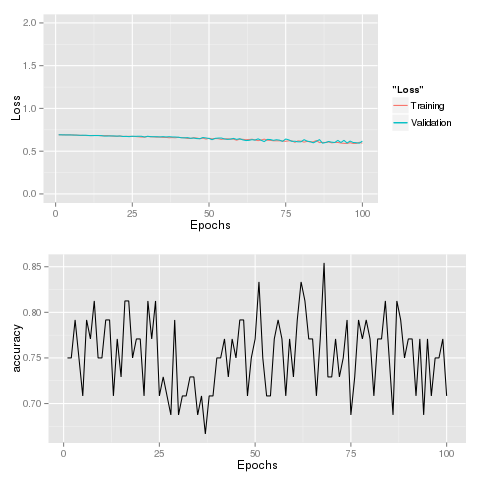

In [13]:
%%R
head(df)
save(file='/tmp/dumm.rd',df) #to use in other interactive RStudio-session using load('/tmp/dumm.rd')
#load('/tmp/dumm.rd')
library(ggplot2)
library(reshape2)
library(quantreg)
library(gridExtra)
p1 = ggplot(df, aes(x=df$epoch, colour='Loss')) + 
  geom_line(aes(y = df$train_loss, colour='Training')) + 
  geom_line(aes(y = df$valid_loss, colour='Validation')) + 
  xlab('Epochs') + ylab('Loss') +
  ylim(c(0,2))
p2 = ggplot(df, aes(x=df$epoch, df$valid_acc)) + geom_line() + xlab('Epochs') + ylab('accuracy')
g <- arrangeGrob(p1, p2, nrow=2)
g
#ggsave(g, file='dumm.png',width=8, height=4)

In [27]:
xi = 100
yi = 100
ddd = X[240:320,:,xi:(xi+48),yi:(yi+48)] 
#res = net_pretrain.predict_proba(ddd)
res1 = net_pretrain.predict(ddd)

ddd = X[0:240,:,xi:(xi+48),yi:(yi+48)] 
#res = net_pretrain.predict_proba(ddd)
res0 = net_pretrain.predict_proba(ddd)
yy = Y[0:360,:,xi:(xi+48),yi:(yi+48)]
yy,res0, res1
res0.max()
res0[:,0]

Made Patches around 
Made Patches around 
Made Patches around 


array([ 0.58981043,  0.58760726,  0.58449191,  0.58854562,  0.59033442,
        0.58879042,  0.59020954,  0.59028   ,  0.58838481,  0.59190166,
        0.59576064,  0.59879106,  0.60404742,  0.61063659,  0.61604434,
        0.61295629,  0.58051717,  0.58213627,  0.58585334,  0.58008653,
        0.58399332,  0.58443147,  0.58427751,  0.5898965 ,  0.58900833,
        0.59249866,  0.59901983,  0.60814917,  0.60947251,  0.61136204,
        0.6107583 ,  0.61080289,  0.5984363 ,  0.59804708,  0.59748918,
        0.59823531,  0.59776241,  0.59716171,  0.5995971 ,  0.59791523,
        0.59828359,  0.60164964,  0.60156333,  0.60205925,  0.60268879,
        0.60661554,  0.60920316,  0.61131102,  0.58131701,  0.58627582,
        0.58011615,  0.57905334,  0.57790565,  0.58070695,  0.58222288,
        0.58520418,  0.58708131,  0.58773386,  0.5855366 ,  0.58491248,
        0.58876491,  0.59097892,  0.59566414,  0.59796143,  0.58891588,
        0.59261358,  0.59619796,  0.59759492,  0.59519047,  0.59

### Makeing predictions

In [15]:
X.shape

(320, 1, 160, 160)

In [19]:
from FirstTry import PIXELS, net1
import sys
from IPython.display import clear_output
yPred = np.zeros((80,1,160, 160)) - 1
dd = range(24,136)
#dd = range(25,110,1)
for xi in dd:
    clear_output()
    print xi
    sys.stdout.flush()
    for yi in dd:
        #ddd = X[240:360,:,xi:(xi+PIXELS),yi:(yi+PIXELS)]   
        ddd = X[240:360,:,(xi-PIXELS/2):(xi+PIXELS/2),(yi-PIXELS/2):(yi+PIXELS/2)]
        res = net_pretrain.predict_proba(ddd)
        #print(str(res.max()) + " " + str(res.shape))
        yPred[:,0,xi,yi] = res[:,1]
yPred.max()
import cPickle as pickle
with open('data/pred.pickle', 'wb') as f:
    pickle.dump(yPred, f, -1)
%ls -rtl data
yPred.max()

135
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patches around 
Made Patc

0.39429894089698792

In [41]:
yPred[1,0,100,100:120]


array([ 0.39263585,  0.39267525,  0.3926301 ,  0.39249697,  0.39251575,
        0.39219669,  0.39198619,  0.39171353,  0.39169511,  0.39184278,
        0.39198795,  0.39176339,  0.3920339 ,  0.39177802,  0.39185101,
        0.39203268,  0.392194  ,  0.39220551,  0.39240402,  0.39229012])

79


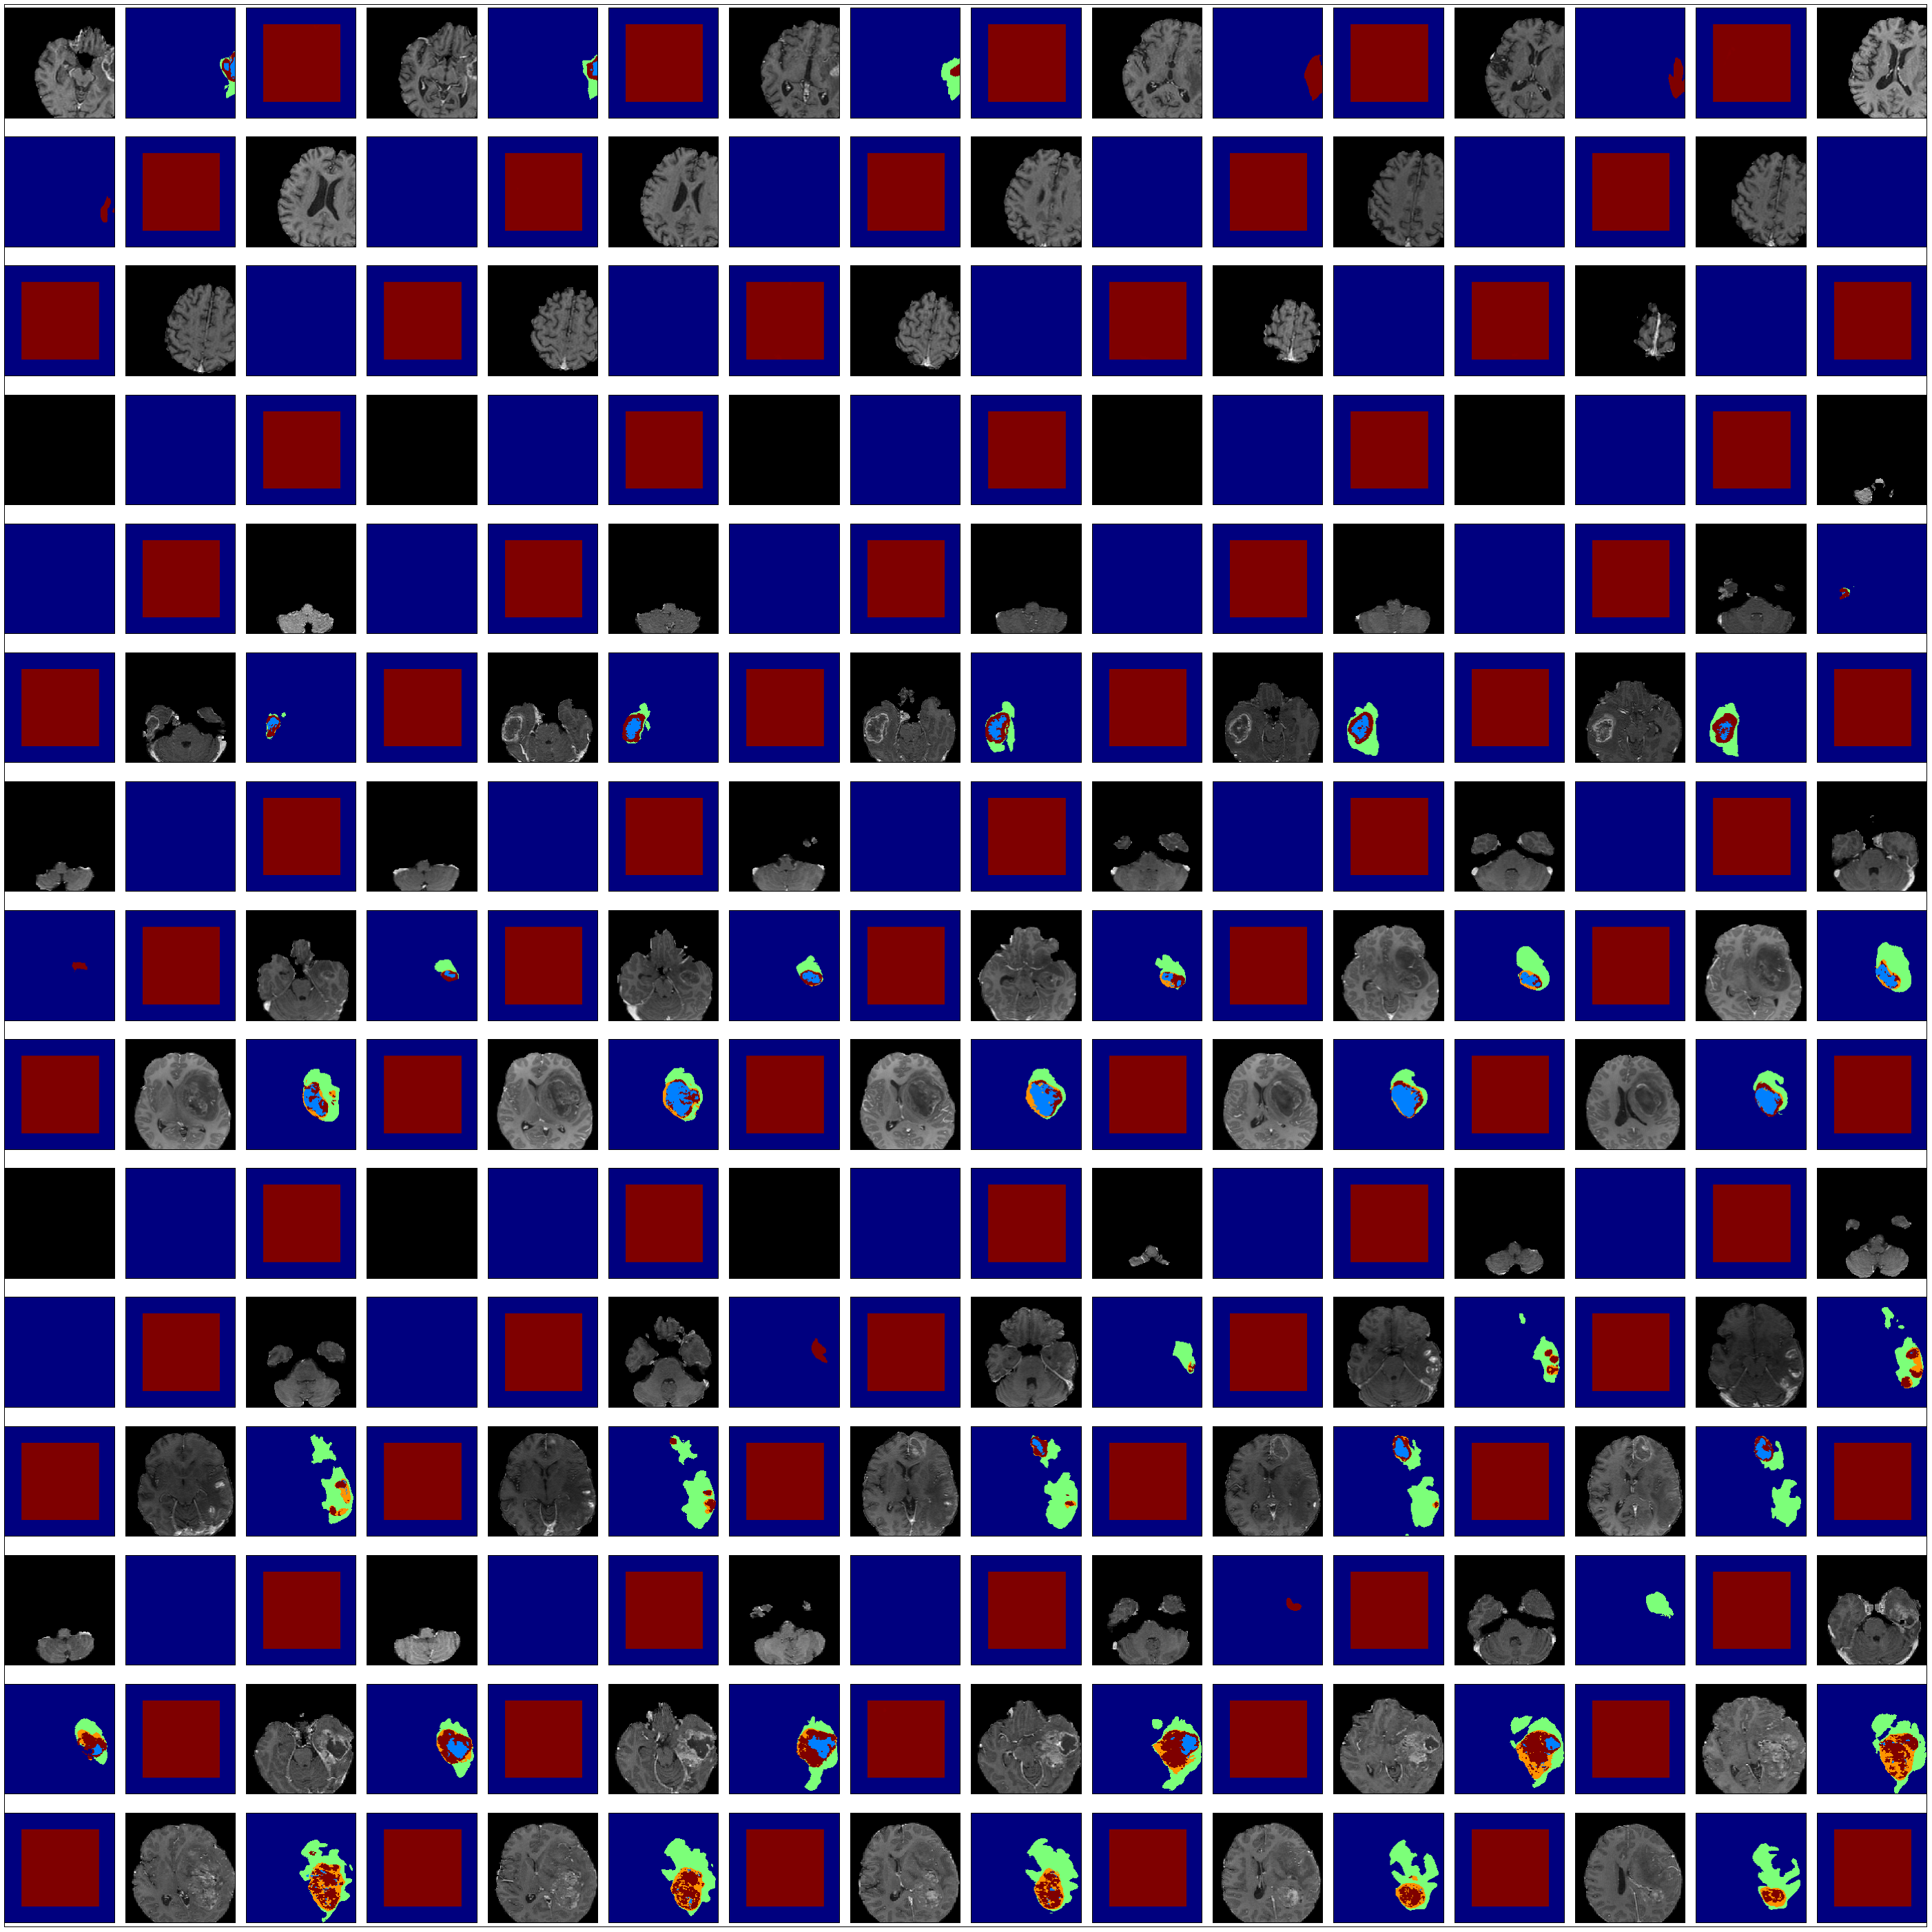

In [44]:
%matplotlib inline
import pylab
import sys
pylab.rcParams['figure.figsize'] = (50.0, 50.0)
fig = plt.figure()
plt.xticks([])
plt.yticks([])
plt.subplots_adjust(hspace=1e-1, wspace=1e-1)
from IPython.display import clear_output
for i,slice in enumerate(range(240,320)):
    clear_output()
    print i
    sys.stdout.flush()
    a = fig.add_subplot(15, 16, (3 * i + 1), xticks=[], yticks=[])  # NB the one based API sucks!
    plt.imshow(X[slice,0,:,:], cmap=plt.get_cmap('gray'))
    a = fig.add_subplot(15, 16, (3 * i + 2), xticks=[], yticks=[])  # NB the one based API sucks!
    plt.imshow(Y[slice,0,:,:])
    a = fig.add_subplot(15, 16, (3 * i + 3), xticks=[], yticks=[])  # NB the one based API sucks!
    plt.imshow(256.0 * yPred[i,0,:,:])
plt.savefig('pred.png')   

In [64]:
plt.savefig('dumm.png')

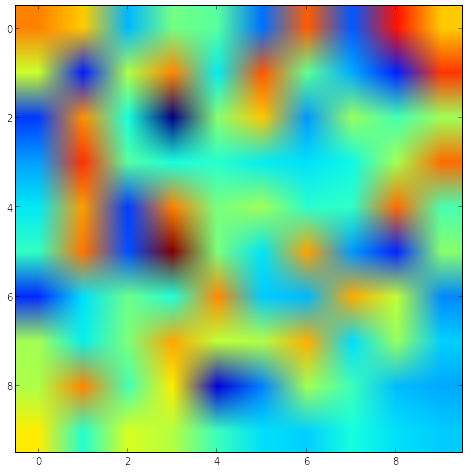

In [21]:
dd = np.random.normal(np.ones((10,10)))
dd.shape
import pylab
pylab.rcParams['figure.figsize'] = (100.0, 8.0)
plt.imshow(dd)
plt.savefig('dumm.png', )

In [ ]:
plot_learning_curves(net1)

In [ ]:
from matplotlib import pyplot

def plot_learning_curves(model):
    

    fig = pyplot.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_color_cycle(['c', 'c', 'm', 'm', 'y', 'y', 'k', 'k', 'g', 'g', 'b', 'b'])

    valid_losses = []
    train_losses = []

   

    valid_loss = np.array([i['valid_loss'] for i in model.train_history_])
    train_loss = np.array([i['train_loss'] for i in model.train_history_])
    valid_loss = np.sqrt(valid_loss) 
    train_loss = np.sqrt(train_loss) 


    valid_losses.append(valid_loss)
    train_losses.append(train_loss)
    ax.plot(valid_loss, linewidth=3)
    ax.plot(train_loss,linestyle='--', linewidth=3, alpha=0.6, label='Train')
    ax.set_xticks([])

    
    ax.legend()
    #ax.set_ylim((0.0, 1.0))
    ax.grid()
    pyplot.ylabel("NLL")
    pyplot.xlabel("Batch")
    pyplot.show()